# Linear least squares fit

## Tasks

Perform a least squares fit of a parabola

$$ y(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

for the seven independent measurments $(x_i, y_i)$ given by $(-0.75, 1.0 \pm 1.0)$, $(-0.5, 4.0 \pm 1.0)$, $(-0.25, 4.0 \pm 0.5)$, $(0.0, 5.5 \pm 0.5)$, $(0.25, 4.5 \pm 0.5)$, $(0.5, 5.5 \pm 1.0)$, $(0.75, 3.0 \pm 1.0)$. 

a) Determine the best fit parameters $\hat \theta_i$ and their covariances using the formula for linear least squares fits.

b) Determine the $\chi_\mathrm{obs}^2$ for the best fit parameter. What is the number of degrees of freedom? Plot the $\chi^2$ distribution and indicate $\chi_\mathrm{obs}^2$ in this plot (e.g. by drawing a line at this value).
What is the $p$-value for this fit?

c) Plot the fitted parabola and the $1\sigma$ error band around it as obtaind from the error propagation formula $\sigma_y^2 = A^\mathrm{T} U A$. What is the predicted value $y$ at $x=1$ and its uncertainty?

d) Compare the fit result and the covariance matrix with the results obtained with iminuit. Do the results agree?

e) Determine the $p$-value for a straight-line fit. Is thhis an acceptable description of the data?


### Hints

1) The following numpy functions might come in very handy
* diagonal matrix from vector v in numpy: *A = np.diagflat(v)*
* matrix from column vectors v0, v1, v2: *A = np.column_stack((v0, v1, v2))*
* multiplication of matrices A and B in numpy: *C = A.dot(B)*
* transposed matrix: *A_T = np.transpose(A)*
* inverse matrix: *A_inv = inv(A)*, this requires *from numpy.linalg import inv*

2) It might be useful to write a function which returns the uncertainty $\sigma_y$ for a numpy array of $x$ values. A function $f$ that only works for a scalar value $x$ can be vectorized (i.e., it works also for numpy arrays) with *numpy.vectorize*.

3) Data points with error bars can be drawn with *plt.errorbar(x, y, yerr=sigma_y)*

4) A band between $y$ values can be drawn with the aid of *matplotlib.pyplot.fill_between*

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1 par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


## Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from iminuit import Minuit
from scipy.special import gamma
from scipy.stats import chi2
from sympy import *
from IPython.display import display, Latex
from my_plot import set_size
import matplotlib as mpl
#mpl.rcParams['hatch.linewidth'] = 1  # previous pdf hatch linewidth

# Using seaborn's style
plt.style.use('seaborn')
plt.rcParams.update({'lines.markeredgewidth': 1})
width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 12pt font in plots, to match 12pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.rcParams.update(tex_fonts)

In [2]:
# data
x = np.array([-0.75, -0.5, -0.25, 0., 0.25, 0.5, 0.75])
y = np.array([1., 4.0, 4., 5.5, 4.5, 5.5, 3])
sigma_y = np.array([1, 1, 0.5, 0.5, 0.5, 1, 1])
def f(x,sigma_0,sigma_1,sigma_2):
    return sigma_0+sigma_1*x+sigma_2*x**2

def error_prop_corr(f, x, V):
    """
    f: function f = f(x[0], x[1], ...)
    x: list of variables
    V: covariance matrix (python 2d list)
    """
    sum = sympify("0") # empty sympy expression
    for i in range(len(x)):
        for j in range(len(x)):
            sum += diff(f, x[i]) * diff(f, x[j]) * V[i][j] 
    return sqrt(simplify(sum))


In [3]:
sigma_0, sigma_1, sigma_2 = 0,0,0
v0 = np.ones(7)
v1 = x
v2 = x**2
A = np.column_stack((v0,v1,v2))
mu = []
Lambda = [sigma_0,sigma_1,sigma_2]
for i in range(len(Lambda)):
    for j in range(len(Lambda)):
        mu.append(A[i][j]*Lambda[j])
C = np.zeros((7,7))
for i in range(7):
        C[i][i]=sigma_y[i]**2
C_inv = inv(C)
A_T = np.transpose(A)
sigmas = np.zeros(3)
G= (inv((A_T.dot(C_inv)).dot(A)).dot(A_T)).dot(C_inv)
for i in range(3):
    for j in range(len(y)):
        sigmas[i] +=G[i][j]*y[j]
a = np.transpose(y-A.dot(sigmas))
a_im = a
chi2_obs = (a.dot(C_inv)).dot(a)
C_lam = inv((A_T.dot(C_inv)).dot(A))
display(Latex("Parameters:"))
display(Matrix(sigmas))
display(Latex("Convariance Matrix"))
display(Matrix(C_lam))

<IPython.core.display.Latex object>

Matrix([
[ 4.99373795761079],
[ 1.29411764705882],
[-4.89402697495183]])

<IPython.core.display.Latex object>

Matrix([
[0.0973025048169557,               0.0, -0.262042389210019],
[               0.0, 0.470588235294118,                0.0],
[-0.262042389210019,               0.0,   1.97302504816956]])

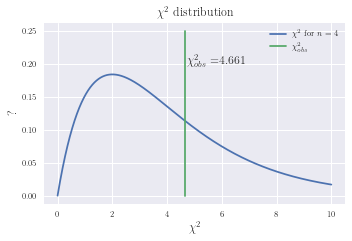

In [4]:
def chi2_dist(chi2_obs,n):
    return (chi2**(n/2 -1)*np.exp(-chi2/2))/(2**(n/2)*gamma(n/2))
chi2_gen = np.linspace(0,10,10000)
chi2_d = chi2.pdf(chi2_gen,4)
plt.figure(figsize=set_size(390))
plt.title(r"$\chi^2$ distribution")
plt.xlabel(r"$\chi^2$")
plt.ylabel("?")
plt.plot(chi2_gen,chi2_d,label=r"$\chi^2$ for $n=4$")
plt.plot([chi2_obs,chi2_obs],[0,0.25],label=r"$\chi^2_{obs}$")
plt.text(chi2_obs+0.05,0.2,s=r"$\chi^2_{}$ =${:.3f}$".format("{obs}",chi2_obs))
plt.legend()
plt.savefig("PDFs/chi2_distribution.pdf",format="PDF")

[0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0]


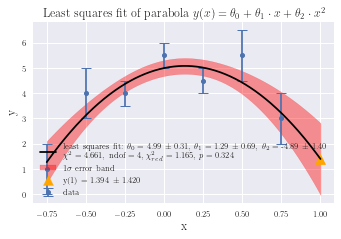

In [5]:
sigma_y_fit = np.sqrt(np.diag(C_lam))
plt.figure(figsize=set_size(390))
plt.title(r"Least squares fit of parabola $y(x) = \theta_0 + \theta_1 \cdot x + \theta_2 \cdot x^2$")
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(x,y,fmt='.',yerr=sigma_y,capsize=5,markersize=8,label="data")
print(mu)
x_c = np.linspace(-0.75,1,1000)
x_f,a,b,c,sigma_a,sigma_b,sigma_c= symbols('x_f,a,sigma_a,b,sigma_b,c,sigma_c', positive=True)
func = a + b*x_f+c*x_f**2
a_meas = sigmas[0]
sigma_a_meas = sigma_y_fit[0]
b_meas = sigmas[1]
sigma_b_meas = sigma_y_fit[1]
c_meas = sigmas[2]
sigma_c_meas = sigma_y_fit[2]
vars = [a,b,c]
sigmas_func = error_prop_corr(func,vars,C_lam)
def sigma_for_x(my_x):
    sigma_func_eval = sigmas_func.subs([(x_f,my_x), (a, a_meas), (b, b_meas), (c, c_meas),(sigma_a , sigma_a_meas),(sigma_b , sigma_b_meas),(sigma_c , sigma_c_meas)]).evalf()
    return sigma_func_eval
my_sigma = []    
for i in x_c:
    my_sigma.append(sigma_for_x(i))
my_sigma = np.array(my_sigma)
lower_bound = f(x_c,*sigmas)-my_sigma.astype(float)
upper_bound = f(x_c,*sigmas)+my_sigma.astype(float)
plt.plot(x_c,f(x_c,*sigmas),color='black',label="least squares fit: $\\theta_0 =$ {:.2f} $\pm$ {:.2f}, $\\theta_1 = $ {:.2f} $\pm$ {:.2f}, $\\theta_2 = $ {:.2f} $\pm$ {:.2f} \n $\chi^2 = $ {:.3f}, ndof = {:.0f}, $\chi^2_{} = $ {:.3f}, $p = $ {:.3f}".format(a_meas,sigma_a_meas,b_meas,sigma_b_meas,c_meas,sigma_c_meas,chi2_obs,len(x)-len(sigmas),"{red}",chi2_obs/(len(x)-len(sigmas)),1-chi2.cdf(chi2_obs,len(x)-len(sigmas))))
plt.fill_between(x_c,lower_bound,upper_bound, color='r',alpha=0.4,label=r"$1 \sigma$ error band")
plt.scatter([1,1],[f(x_c,*sigmas)[-1],f(x_c,*sigmas)[-1]],100,marker="^",color="orange",label=r"y(1) = {:.3f} $\pm$ {:.3f}".format(f(x_c,*sigmas)[-1],sigma_for_x(1)))
plt.legend()
plt.savefig("PDFs/manual_parabola_fit.pdf",format="PDF")

In [6]:
def LSQ(a, b,c):
    return np.sum((y - f(x, a, b,c)) ** 2 / sigma_y ** 2)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
LSQ.errordef = Minuit.LEAST_SQUARES
m = Minuit(LSQ,a=5,b=1.3,c=-5 )

In [7]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.661                      │              Nfcn = 45               │
│ EDM = 2.19e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   4.99    │   0.31    │            │            │         │         │       │
│ 1 │ b    │    1.3    │    0.7    │            │            │         │         │       │
│ 2 │ c    │   -4.9    │    1.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │    0.0973 -5.25e-11    -0.262 │
│ b │ -5.25e-11     0.471  3.96e-10 │
│ c │    -0.262  3.96e-10      1.97 │
└───┴───────────────────────────────┘

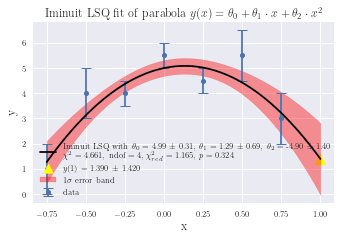

In [8]:
theta_0 = m.values["a"]
theta_1 = m.values["b"]
theta_2 = m.values["c"]

sigma_0 = m.errors["a"]
sigma_1 = m.errors["b"]
sigma_2 = m.errors["c"]

def sigma_for_x_minuit(my_x):
    sigma_func_eval = sigmas_func.subs([(x_f,my_x), (a, theta_0), (b, theta_1), (c, theta_2),(sigma_a , sigma_0),(sigma_b , sigma_1),(sigma_c , sigma_2)]).evalf()
    return sigma_func_eval
my_sigma_minuit = []    
for i in x_c:
    my_sigma_minuit.append(sigma_for_x_minuit(i))
my_sigma_minuit = np.array(my_sigma_minuit)

lower_bound = f(x_c,theta_0,theta_1,theta_2)-my_sigma_minuit.astype(float)
upper_bound = f(x_c,theta_0,theta_1,theta_2)+my_sigma_minuit.astype(float)

plt.figure(figsize=set_size(390))
plt.title(r"Iminuit LSQ fit of parabola $y(x) = \theta_0 + \theta_1 \cdot x + \theta_2 \cdot x^2$")
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(x,y,yerr=sigma_y,markersize=8,capsize=5,fmt=".",label="data")
plt.plot(x_c,f(x_c,theta_0,theta_1,theta_2),color="black",label="Iminuit LSQ with $\\theta_0 = $ {:.2f} $\pm$ {:.2f}, $\\theta_1 = $ {:.2f} $\pm$ {:.2f}, $\\theta_2 = $ {:.2f} $\pm$ {:.2f} \n $\chi^2 = $ {:.3f}, ndof = {:.0f}, $\chi^2_{} = $ {:.3f}, $p = $ {:.3f}".format(theta_0,sigma_0,theta_1,sigma_1,theta_2,sigma_2,m.fval,len(x)-m.nfit,"{red}",m.fval/(len(x)-m.nfit),1-chi2.cdf(m.fval,len(x)-m.nfit)))
plt.scatter([1,1],[f(x_c,theta_0,theta_1,theta_2)[-1],f(x_c,theta_0,theta_1,theta_2)[-1]],100,marker="^",color="yellow",label=r"$y(1) = $ {:.3f} $\pm$ {:.3f}".format(f(x_c,theta_0,theta_1,theta_2)[-1],my_sigma_minuit[-1]))
plt.fill_between(x_c,lower_bound,upper_bound, color='r',alpha=0.4,label=r"$1 \sigma$ error band")
plt.legend()
plt.savefig("PDFs/iminuit_parabola_fit.pdf",format="PDF")

As one can see above, the fit parameters, their errors, as well as the covariance matrix, are within agreement.

In [9]:
def line(x,a,b):
    return a*x + b
def LSQ_line(a,b):
    return np.sum((y - line(x, a, b)) ** 2 / sigma_y ** 2)
LSQ_line.errordef = Minuit.LEAST_SQUARES
m = Minuit(LSQ_line,a=1,b=5 )

In [10]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.8                       │              Nfcn = 22               │
│ EDM = 3.98e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    1.3    │    0.7    │            │            │         │         │       │
│ 1 │ b    │   4.34    │   0.25    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │     0.471 -7.18e-11 │
│ b │ -7.18e-11    0.0625 │
└───┴─────────────────────┘

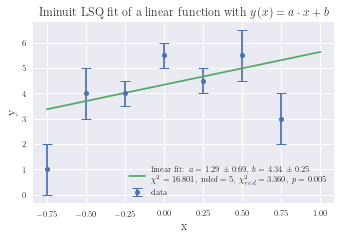

In [11]:
a = m.values["a"]
b = m.values["b"]
a_err = m.errors["a"]
b_err = m.errors["b"]
C_im = m.covariance

plt.figure(figsize=set_size(390))
plt.title("Iminuit LSQ fit of a linear function with $y(x) = a \cdot x + b$")
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(x,y,yerr=sigma_y,capsize=5,markersize=8,fmt=".",label="data")
plt.plot(x_c,line(x_c,a,b),label="linear fit: $a = $ {:.2f} $\pm$ {:.2f}, $b = $ {:.2f} $\pm $ {:.2f} \n $\chi^2 = $ {:.3f}, ndof = {:.0f}, $\chi^2_{} = $ {:.3f}, $p = $ {:.3f}".format(a,a_err,b,b_err,m.fval,len(x)-m.nfit,"{red}",m.fval/(len(x)-m.nfit),1-chi2.cdf(m.fval,len(x)-m.nfit)))
plt.legend()
plt.savefig("PDFs/iminuit_linear_fit.pdf",format="PDF")

The line fit has a low p-value and is hence not an acceptable description of the data.